# DVD Rental database
База представляет бизнес процессы магазина по аренде DVD.

В ней содержится 15 таблиц:

1. actor – хранит данные об актерах, включая их имя и фамилию.
2. film – хранит данные о фильмах, такие как название, год выпуска, продолжительность, рейтинг и т.д.
3. film_actor – хранит связи между фильмами и актерами.
4. category – хранит категории фильмов
5. film_category - хранит взаимосвязи между фильмами и категориями.
6. store – хранит данные магазина, включая управляющий состав и адрес.
7. inventory – хранит инвентарные номера фильмов по магазинам.
8. rental – хранит данные об аренде.
9. payment – хранит платежи клиентов.
10. staff – хранит данные персонала магазинов.
11. customer – хранит данные клиентов.
12. address – хранит адреса для персонала и клиентов.
13. city – хранит имена городов.
14. country – хранит названия стран.
15. language – хранит языки фильмов.

![схема базы](https://sp.postgresqltutorial.com/wp-content/uploads/2018/03/dvd-rental-sample-database-diagram.png)

**В таблице film удалены колонки rental_duration, rental_rate и replacement_cost. Стоимость определяется только по таблице payment**

У всех пользователей student_x есть доступ на чтение к этой базе данных. Название **dvdrental**.

# Что предстоит сделать?
1. Провести ABC анализ ассортимента. Проверить выполняется ли для этих данных правило Парето? Если нет, то приведите подходящее на ваш взгляд разбиение
2. На основе полученного (общего) анализа ассортимента, оцените средний объем недельной выручки в каждой категории в привязке к дате начала аренды. В какой категории эта оценка имеет меньший разброс?



In [ ]:
!pip install psycopg2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

DB_HOST = None
DB_USER = None
DB_USER_PASSWORD = None
DB_NAME = 'dvdrental'

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)

#### ABC анализ ассортимента

Цель проведения ABC анализа: 
*  Выделить наиболее важные товары по прибыли

##### Этапы проведения ABC анализа

В данном случае, мы можем прийти к решению за несколько шагов:

1. Посчитаем выручку за каждую позицию
2. Сгруппируем наши данные по идентификатору товара, и возьмем сумму по выручке
3. Посчитаем суммарную выручку, и для каждого товара посмотрим какой вклад в общую выручку вносит каждый товар
4. Отсортируем список с процентами "вклада", посчитаем еще один столбец с кумулятивной суммой по процентам
5. На основе полученной таблицы, определим группы ABC

#### Найдем наиболее важные товары для нашего магазина

#### Выгрузим данные из базы данных. Для ABC анализа нам понадобятся столбцы:
*  film_id
*  amount
*  rental_date

In [ ]:

data = pd.read_sql_query('''
SELECT 
    film_id,
    amount,
    EXTRACT(WEEK FROM rental_date) AS week_number
FROM (  
  SELECT
    payment.rental_id,
    film.film_id,
    payment.amount,
    rental.rental_date
  FROM film INNER JOIN inventory
       ON film.film_id = inventory.film_id
       INNER JOIN rental
       ON inventory.inventory_id = rental.inventory_id
       INNER JOIN payment
       ON rental.rental_id = payment.rental_id) AS t
''', conn)
data

,film_id,amount,week_number
0,257,3.99,24.0
1,257,0.99,24.0
2,323,5.99,24.0
3,323,4.99,24.0
4,803,4.99,24.0
...,...,...,...
14591,168,30.15,34.0
14592,951,22.93,34.0
14593,452,31.00,34.0
14594,439,21.93,34.0


###### Проведение ABC анализа при помощи SQL

In [ ]:
abc_sql = pd.read_sql_query('''
SELECT 
  film_id,
  amount,
  sum_amount,
  sum_amount/sum(sum_amount) over() as percent,
  sum(sum_amount) over(order by sum_amount DESC, film_id) as sum_prod,
  rank() over(order by sum_amount DESC, film_id) as ranks,
  sum(sum_amount) over() as sum_sale,
  sum(sum_amount) over(order by sum_amount DESC, film_id) / sum(sum_amount) OVER() AS ratio_films,
  CASE
    WHEN sum(sum_amount) over(order by sum_amount DESC, film_id) / sum(sum_amount) over() < 0.8 THEN 'A'
    WHEN sum(sum_amount) over(order by sum_amount DESC, film_id) / sum(sum_amount) over() BETWEEN 0.8 AND 0.95 THEN 'B'
  ELSE 'C'
  END AS category,
  EXTRACT(WEEK FROM rental_date) AS number_week
FROM
     (
        SELECT DISTINCT
               film.film_id,
               SUM(payment.amount) OVER(PARTITION BY film.film_id) AS sum_amount,
               rental.rental_date,
               payment.amount
        FROM 
          film INNER JOIN inventory
          ON film.film_id = inventory.film_id
          INNER JOIN rental
          ON inventory.inventory_id = rental.inventory_id
          INNER JOIN payment
          ON rental.rental_id = payment.rental_id
     ) as t
''', conn)
abc_sql

,film_id,amount,sum_amount,percent,sum_prod,ranks,sum_sale,ratio_films,category,number_week
0,973,35.12,930.62,0.000141,25126.74,1,6589610.32,0.003813,A,30.0
1,973,34.85,930.62,0.000141,25126.74,1,6589610.32,0.003813,A,27.0
2,973,34.01,930.62,0.000141,25126.74,1,6589610.32,0.003813,A,27.0
3,973,32.98,930.62,0.000141,25126.74,1,6589610.32,0.003813,A,34.0
4,973,35.52,930.62,0.000141,25126.74,1,6589610.32,0.003813,A,33.0
...,...,...,...,...,...,...,...,...,...,...
14587,257,3.99,36.90,0.000006,6589610.32,14583,6589610.32,1.000000,C,30.0
14588,257,3.99,36.90,0.000006,6589610.32,14583,6589610.32,1.000000,C,33.0
14589,257,5.99,36.90,0.000006,6589610.32,14583,6589610.32,1.000000,C,28.0
14590,257,0.99,36.90,0.000006,6589610.32,14583,6589610.32,1.000000,C,33.0


##### ABC анализ при помощи Pandas

In [ ]:
summary = data['amount'].sum()
ratio = data.groupby('film_id')['amount'].sum()
ratio

film_id
1       563.54
2       135.28
3       341.92
4       416.05
5       208.70
         ...  
996     133.72
997     199.13
998     213.69
999     425.10
1000    911.81
Name: amount, Length: 958, dtype: float64

In [ ]:
#Найдем суммарную выручку и вклад каждого товара в общую выручку
summary = data['amount'].sum()
ratio = data.groupby('film_id')['amount'].sum()/summary
ratio

film_id
1       0.001503
2       0.000361
3       0.000912
4       0.001110
5       0.000557
          ...   
996     0.000357
997     0.000531
998     0.000570
999     0.001134
1000    0.002432
Name: amount, Length: 958, dtype: float64

In [ ]:
#Отсортируем полученный вклад по убыванию
stocks = ratio.sort_values(ascending = False)
stocks

film_id
973     0.002483
767     0.002469
1000    0.002432
361     0.002267
31      0.002248
          ...   
196     0.000248
584     0.000235
803     0.000232
323     0.000184
257     0.000098
Name: amount, Length: 958, dtype: float64

In [ ]:
#Найдем кумулятивную сумму вклада
stocks_cumsum = stocks.cumsum()
stocks_cumsum

film_id
973     0.002483
767     0.004952
1000    0.007384
361     0.009651
31      0.011898
          ...   
196     0.999251
584     0.999486
803     0.999718
323     0.999902
257     1.000000
Name: amount, Length: 958, dtype: float64

In [ ]:
def abc_segmentation(perc):
  if perc < 0.8:
    return 'A'
  if perc >= 0.8 and perc < 0.95:
    return 'B'
  if perc >= 0.95:
    return 'C'

In [ ]:
#Воспользуемся функцией и присвоим категорию товарам
segmentation = stocks_cumsum.apply(abc_segmentation)
segmentation

film_id
973     A
767     A
1000    A
361     A
31      A
       ..
196     C
584     C
803     C
323     C
257     C
Name: amount, Length: 958, dtype: object

In [ ]:
#Создадим таблицу с итогом ABC анализа
abc_data = pd.DataFrame({'stocks':stocks,
              'stocks_cumsum': stocks_cumsum,
              'segmentation': segmentation})
abc_data

,stocks,stocks_cumsum,segmentation
film_id,,,
973,0.002483,0.002483,A
767,0.002469,0.004952,A
1000,0.002432,0.007384,A
361,0.002267,0.009651,A
31,0.002248,0.011898,A
...,...,...,...
196,0.000248,0.999251,C
584,0.000235,0.999486,C
803,0.000232,0.999718,C


По итогу ABC анализа сделаем график с распределением групп

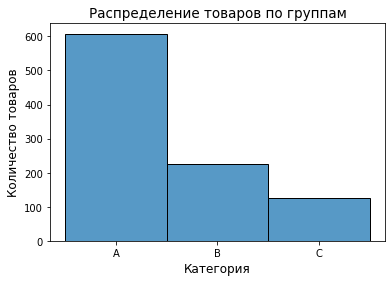

In [ ]:
sns.histplot(abc_data['segmentation'])
plt.xlabel('Категория',fontsize = 12)
plt.ylabel('Количество товаров', fontsize = 12)
plt.title('Распределение товаров по группам', fontsize = 13.5)
plt.show()


Узнам вклад каждой категории

In [ ]:
values = abc_data['segmentation'].value_counts()
for n,i in enumerate(values):
  sum = values.sum()
  ratio = i/values.sum()
  group = values.index[n]
  print(f'Вклад категории {group}: {ratio.round(3)}')

Вклад категории A: 0.635
Вклад категории B: 0.235
Вклад категории C: 0.13


Как видим, принцип Парето здесь не работает и больше подходит соотношение 63,5% 23,5% 13%

Соеденим исходную таблицу и таблицу с результатами ABC анализа

In [ ]:
data_with_abc = data.merge(abc_data['segmentation'], how = 'inner', left_on = 'film_id', right_index= True)
data_with_abc

,film_id,amount,week_number,segmentation
0,257,3.99,24.0,C
1,257,0.99,24.0,C
7,257,0.99,33.0,C
9,257,3.99,33.0,C
18,257,1.99,33.0,C
...,...,...,...,...
8213,884,28.34,30.0,C
8304,884,29.28,30.0,C
10771,884,27.35,33.0,C
12170,884,28.12,33.0,C


#### На основе полученного (общего) анализа ассортимента, оценим средний объем недельной выручки в каждой категории в привязке к дате начала аренды. Узнаем в какой  категории эта оценка имеет меньший разброс.

Найдём средний объём недельной выручки в каждой категории

In [ ]:
mean_renevue_week = data_with_abc.groupby(['segmentation', 'week_number']).agg({'amount': np.mean})
mean_renevue_week

amount
segmentation week_number           
A            7.0          26.317586
             24.0         26.292633
             25.0         26.394512
             27.0         26.398888
             28.0         26.002995
             30.0         26.227241
             31.0         26.567321
             33.0         26.215355
             34.0         26.546926
B            7.0          22.868148
             24.0         23.747788
             25.0         24.605422
             27.0         23.913664
             28.0         24.021509
             30.0         23.755952
             31.0         24.133861
             33.0         24.011016
             34.0         23.847087
C            7.0          23.203000
             24.0         21.724286
             25.0         21.384828
             27.0         22.338777
             28.0         21.675306
             30.0         22.117812
             31.0         22.912222
             33.0         21.898934
             34.0         22.756667

Из таблицы мы видим, что средний объём недельной выручки в категории "А" находится в диапазоне от 26.0 до 26.7\
В категории "B" он от 22.8 до 24.6\
А в категории "C" от 21.1 до 23.2 

Посмотрим, как эти данные будут выглядеть на графике.


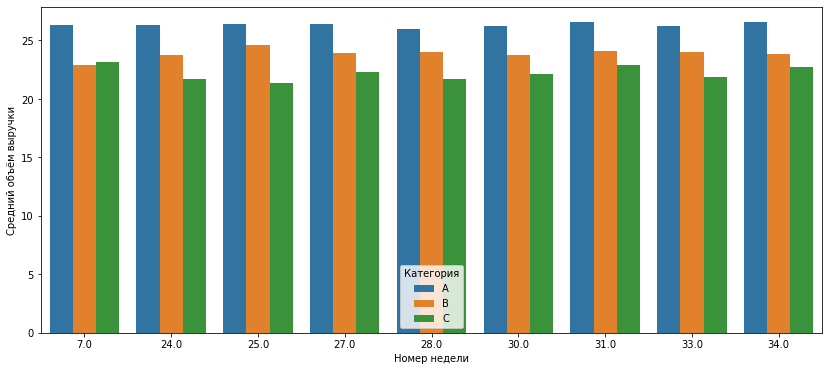

In [ ]:
no_id_data = mean_renevue_week.reset_index()
plt.figure(figsize = (14,6))
sns.barplot(data = no_id_data, x = 'week_number', y = 'amount', hue = 'segmentation')
plt.xlabel('Номер недели')
plt.ylabel('Средний объём выручки')
plt.legend(loc = 'lower center', title = 'Категория')
plt.show()

Посмотрев на график, мы увидим, что в категории "A" средний объём недельной выручки приближен к равномерному распределению, а в остальных категориях он менее приближен к равномерному распределению.


Посмотрим с другой стороны на разброс средних значений недельной выручки.


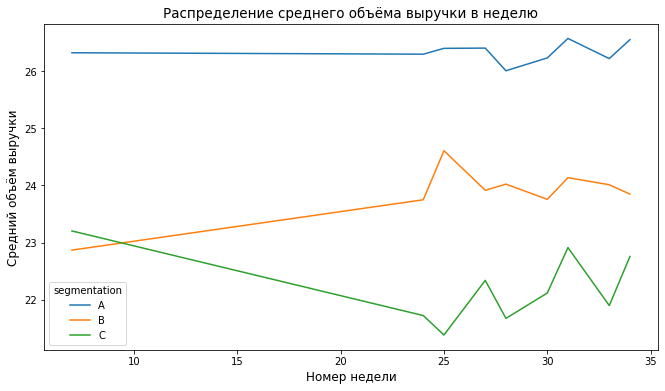

In [ ]:
plt.figure(figsize = (11,6))
sns.lineplot(data = mean_renevue_week.reset_index(), x = 'week_number', y = 'amount', hue = 'segmentation')
plt.title('Распределение среднего объёма выручки в неделю', fontsize = 13.5)
plt.xlabel('Номер недели', fontsize = 12)
plt.ylabel('Средний объём выручки', fontsize = 12)
plt.show()

График выше отображает распределение среднего объёма выручки за неделю.\
На линейчатом графике по оси "X" расположен номер недели, а по оси "Y" средний объём выручки за каждую неделю.\
Из графика мы видим, что наименьший разброс среднего имеет категория "A", а наибольший - категория "С"